# Word-Level LSTM Text Generation (Multi-file Support)

This notebook demonstrates how to train a word-level LSTM model for text generation using multiple text files as input.

You will:
- Load and concatenate multiple text files
- Tokenize at the word level
- Build a vocabulary
- Prepare training sequences
- Build and train an LSTM model
- Generate text from a seed
- Save and load your vocab/model

----

## 1. Setup & Imports

In [13]:
!pip install numpy keras matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 23.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 22.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import os
import re
from collections import Counter
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

2025-06-23 18:35:55.871446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750696556.003195   28794 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750696556.039367   28794 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750696556.367827   28794 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750696556.367891   28794 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750696556.367900   28794 computation_placer.cc:177] computation placer alr

## 2. Load and Concatenate Text Files

In [2]:
# List your training files here:
training_files = [
    'dataset/conversation_1.txt',
    'dataset/movie_scripts.txt',
    'dataset/sherlock.txt'
]

# Load and concatenate all text
all_text = ''
for fname in training_files:
    with open(fname, 'r', encoding='utf-8') as f:
        all_text += f.read() + ' '
print(f"Loaded {len(all_text):,} characters from {len(training_files)} files.")

Loaded 36,109,627 characters from 3 files.


## 3. Tokenize and Build Vocabulary

In [3]:
def tokenize(text):
    # Lowercase and split on word boundaries
    return re.findall(r"\b\w+\b", text.lower())

tokens = tokenize(all_text)
print(f"Total tokens: {len(tokens):,}")

# Optionally, filter out rare words
min_freq = 1  # set >1 to filter rare words
freq = Counter(tokens)
vocab = sorted([w for w, c in freq.items() if c >= min_freq])
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Total tokens: 7,074,537
Vocabulary size: 71126


## 4. Build Training Sequences

In [ ]:
seq_lenght = 10  # context window, adjust as needed
step = 1         # sliding window step size

input_sequences = []
target_words = []
for i in range(0, len(tokens) - seq_lenght, step):
    seq = tokens[i:i+seq_lenght]
    target = tokens[i+seq_lenght]
    # Only keep if all words in vocab
    if all(w in word2idx for w in seq + [target]):
        input_sequences.append([word2idx[w] for w in seq])
        target_words.append(word2idx[target])
input_sequences = np.array(input_sequences)
target_words = np.array(target_words)
print(f"Number of sequences: {len(input_sequences):,}")

Number of sequences: 7,074,527


## 5. Build the Model

In [ ]:
embedding_dim = 100
hidden_dim = 256

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_lenght),
    LSTM(hidden_dim, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.build(input_shape=(None, seq_lenght))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 10, 100)        │     7,112,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 71126)          │    18,279,382 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,757,550 (98.26 MB)

 Trainable params: 25,757,550 (98.26 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [11]:
batch_size = 128
epochs = 40
callbacks = [
    ModelCheckpoint('word_prediction.keras', save_best_only=True),
    EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    input_sequences, target_words,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=callbacks
)

2025-06-23 18:41:24.547364: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 509365920 exceeds 10% of free system memory.
2025-06-23 18:41:25.079601: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 509365920 exceeds 10% of free system memory.


Epoch 1/40
49743/49743 ━━━━━━━━━━━━━━━━━━━━ 1405s 28ms/step - loss: 5.3183 - val_loss: 5.4437
Epoch 2/40
49743/49743 ━━━━━━━━━━━━━━━━━━━━ 1392s 28ms/step - loss: 4.5867 - val_loss: 5.4084
Epoch 3/40
42878/49743 ━━━━━━━━━━━━━━━━━━━━ 2:56 26ms/step - loss: 4.4173

KeyboardInterrupt: 

### (Optional) Plot Training/Validation Loss

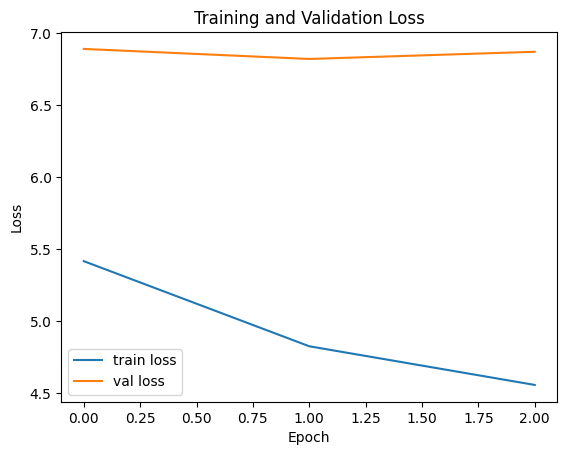

In [11]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

## 7. Save Vocabulary and Model

In [12]:
np.savez_compressed('word_vocab.npz', word2idx=word2idx, idx2word=idx2word)
# Model already saved as 'word_lstm_best.h5' by ModelCheckpoint

## 8. Generate Text From a Seed

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def predict_next_words(model, seed_text, word2idx, idx2word, seq_lenght, num_words=10, temperature=1.0):
    words = seed_text.lower().split()
    for _ in range(num_words):
        seq = [word2idx.get(w, 0) for w in words[-seq_lenght:]]
        if len(seq) < seq_lenght:
            seq = [0]*(seq_lenght - len(seq)) + seq
        x = np.array([seq])
        preds = model.predict(x, verbose=0)[0]
        next_idx = sample(preds, temperature)
        next_word = idx2word.get(next_idx, '')
        words.append(next_word)
    return ' '.join(words)

### Example: Generate 20 words given a seed

In [ ]:
# Load model and vocab if needed
# model = load_model('word_lstm_best.h5')
# data = np.load('word_vocab.npz', allow_pickle=True)
# word2idx = data['word2idx'].item()
# idx2word = data['idx2word'].item()

seed = "I am very happy to be here today because I am very happy to annouce "
generated = predict_next_words(
    model, seed, word2idx, idx2word, seq_lenght=seq_lenght, num_words=1, temperature=0.8
)
print(generated)

i am very happy to be here today because i am very happy to annouce my


> **Tip:** For best results, use a seed that is at least as long as `seq_lenght` (or pad with zero-indexed words).